# Installation of dependencies

In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn nltk

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import nltk
import seaborn as sns
import matplotlib

# Data preprocessing################################
# Remove useless words
from nltk.corpus import stopwords

# Aggressive conversion of words to base form
from nltk.stem.lancaster import LancasterStemmer

# Import packages that help us to create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Data preprocessing################################

# Data visualization################################

# For creating graphs
from matplotlib import pyplot as plt
# Data visualization################################

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

# Setting the dtype policy to utilize mixed precision
# This will use the tensor cores of the GPU
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [4]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [5]:
# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Import ML algos
from sklearn.svm import LinearSVC

# 

# Load the dataset

In [6]:
os.path.join('train_colab', 'train.csv')

'train_colab\\train.csv'

In [7]:
df = pd.read_csv(os.path.join('train_colab', 'train.csv'))

In [8]:
df.iloc[3]['TextComment']

'china teammate so toxic'

In [9]:
df[df.columns[2:]].iloc[3]

Toxic              1
SevereToxicity     0
ObsceneLanguage    0
Insult             1
Name: 3, dtype: int64

#

# Dataset overview
The overview will conclude a discussion with the dataset using exploratory data analysis.

In [10]:
# Show rows of the dataset
len(df)

128606

In [11]:
# Check percentage of comments that are toxic compared to normal comments
df.Toxic.value_counts(normalize=True)

0    0.889655
1    0.110345
Name: Toxic, dtype: float64

This states that approximately 11.03% of the dataset is toxic compared to normal comments.

In [12]:
# Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
df_count=df.iloc[:,2:].sum()

# Print dataset summary
df_count

Toxic              14191
SevereToxicity      1597
ObsceneLanguage     7889
Insult              7499
dtype: int64

# 

# Data visualization

In [13]:
print(df_count.index)

Index(['Toxic', 'SevereToxicity', 'ObsceneLanguage', 'Insult'], dtype='object')


C:\Anaconda\envs\tf_2.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


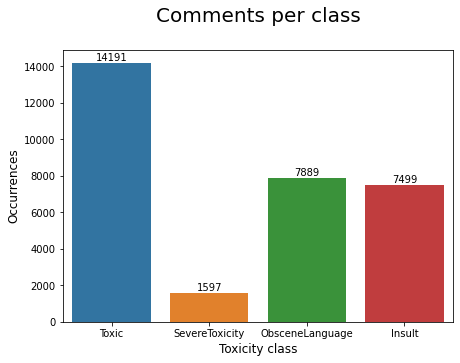

In [14]:
# Plot a chart with the following size
plt.figure(figsize=(7,5))

# Plot a bar chart using the index (category values) and the count of each category. 
# To make the bars more translucent, modify alpha value
ax = sns.barplot(df_count.index, df_count.values, alpha=1)

plt.title("Comments per class\n", fontsize=20)
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Toxicity class', fontsize=12)

# Adding the text labels for each bar
rects = ax.patches
labels = df_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

plt.show()

In [15]:
rowdata = len(df)

pctdata = df_count.values / rowdata * 100
pctdata

array([11.0344774 ,  1.24177721,  6.13423946,  5.83098767])

### This concludes that the percentage of toxicity classes are:
    - Toxicity: 11.03%
    - Severe Toxicity: 1.24%
    - Obscene Language: 6.13%
    - Insult: 5.83%

#

# Data preprocessing

In [16]:
import re
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Re-download stopwords for backup
nltk.download('stopwords')
nltk.download('punkt')

# Setup stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maltesers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maltesers\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
# Remove numbers, capital letters, punctuation, '\n'
import re
import string

# Remove all random numbers with attached letters
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - Convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
filter_line = lambda x: re.sub("\n", " ", x)

# Remove all Non-ASCII characters 
filter_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
df['TextComment'] = df['TextComment'].map(alphanumeric).map(punc_lower).map(filter_line).map(filter_non_ascii)

In [18]:
# Loop through your rows
for sent in df['TextComment']:

    # tokenize
    tokenized_sent = nltk.word_tokenize(sent)

    # remove stops
    tokenized_sent_no_stops = [
        tok for tok in tokenized_sent 
        if tok not in stop_words
    ]

    # untokenize 
    untokenized_sent = TreebankWordDetokenizer().detokenize(
        tokenized_sent_no_stops
    )

In [19]:
# View comment
df['TextComment'][50000]

'your new user tags   hey man   i just noticed that you put a little tag on your user page saying that vandals dont like you  that is most certainly not the case    well  at least not as far as i m concerned  the only reason that i keep screwing around with you is because you re the only admin that s banned me who has a memorable  easy to spell name  honestly  it s nothing personal   just trying to put a smile on your face '

In [20]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing import text, sequence

In [21]:
X = df['TextComment']
y = df[df.columns[2:]].values

In [22]:
df.columns

Index(['id', 'TextComment', 'Toxic', 'SevereToxicity', 'ObsceneLanguage',
       'Insult'],
      dtype='object')

In [23]:
df[df.columns[1:]]

,TextComment,Toxic,SevereToxicity,ObsceneLanguage,Insult
0,go back to your country smelly arab,0,1,0,1
1,russian why u mad bitch,0,1,1,1
2,hey man i m really not trying to edit war it...,0,0,0,0
3,china teammate so toxic,1,0,0,1
4,you sir are my hero any chance you remember...,0,0,0,0
...,...,...,...,...,...
128601,baiter fucking idiot,0,1,1,1
128602,you should be ashamed of yourself that is a h...,0,0,0,1
128603,fking noob,0,1,1,1
128604,and it looks like it was actually you who put ...,0,0,0,0


In [24]:
MAX_WORDS = 250000 # number of words in the vocab

In [25]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                               output_sequence_length=1800,
                               output_mode='int')

In [26]:
#tokenizer=text.Tokenizer(MAX_WORDS, oov_token=oov_tok)
#tokenizer.fit_on_texts(list(x))
#tokenized=tokenizer.texts_to_sequences(x)
#X_train=sequence.pad_sequences(tokenized,maxlen=max_text_len, padding=padding_type, truncating=trunc_type)

In [27]:
type(X.values)

numpy.ndarray

In [28]:
vectorizer.adapt(X.values)

In [29]:
vectorized_text = vectorizer(X.values)

In [30]:
vectorizer('Hello, test')[:2]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([376, 698], dtype=int64)>

In [31]:
vectorized_text

<tf.Tensor: shape=(128606, 1800), dtype=int64, numpy=
array([[  112,   155,     3, ...,     0,     0,     0],
       [ 1117,    76,   188, ...,     0,     0,     0],
       [  322,   367,     4, ...,     0,     0,     0],
       ...,
       [25107,  6365,     0, ...,     0,     0,     0],
       [    6,    11,   525, ...,     0,     0,     0],
       [    6,     4,   123, ...,     0,     0,     0]], dtype=int64)>

In [32]:
len(X)

128606

In [33]:
# Particularly helpful if you have a large dataset
# This is a data pipeline
# MCShBP - map, cache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [34]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [35]:
batch_X.shape

(16, 1800)

In [36]:
tf.data.Dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None)>

In [37]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [38]:
train_generator = train.as_numpy_iterator()

In [39]:
train_generator.next()

(array([[ 91346,   1219,    841, ...,      0,      0,      0],
        [     4,     57,     22, ...,      0,      0,      0],
        [    63,   1441,      6, ...,      0,      0,      0],
        ...,
        [     2,    585,  29950, ...,      0,      0,      0],
        [   493,  10981, 113494, ...,      0,      0,      0],
        [     4,    187,      2, ...,      0,      0,      0]], dtype=int64),
 array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=int64))

# Sequential Models

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [41]:
#Bidirectional??

In [42]:
#LSTM??

In [43]:
#Dense??

In [44]:
model = Sequential()

# Create the embedding layer
model.add(Embedding(MAX_WORDS+1, 32))

# Dropout layer
model.add(Dropout(0.4))

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Feature extractor Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
# Dropout layer
model.add(Dropout(0.4))

# Final layer 
model.add(Dense(4, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          8000032   
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [45]:
# We will use Adam
# Adam(learning rate)
optimizers = tf.keras.optimizers.Adam(0.0001)

In [46]:
model.compile(loss='BinaryCrossentropy', optimizer=optimizers)

# Training the model and displaying chart containing Loss and Validation Loss
**_val_loss_** is the value of cost function for your cross-validation data. <br>
**_loss_** is the value of cost function for your training data.

On validation data, neurons using drop out do not drop random neurons. The reason is that during training we use drop out in order to add some noise for avoiding over-fitting. During calculating cross-validation, we are in the recall phase and not in the training phase. We use all the capabilities of the network.

In [47]:
#X_train,batch_X,y_train,batch_y=train_test_split(X_train,y,test_size=0.15,random_state=1)

In [48]:
# Train the dataset
# Epoch = how many passes for dataset
batch_size=64
archive=model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
5626/5626 [==============================] - 451s 79ms/step - loss: 0.1573 - val_loss: 0.0963
Epoch 2/20
5626/5626 [==============================] - 452s 80ms/step - loss: 0.0939 - val_loss: 0.0812
Epoch 3/20
5626/5626 [==============================] - 449s 80ms/step - loss: 0.0827 - val_loss: 0.0713
Epoch 4/20
5626/5626 [==============================] - 445s 79ms/step - loss: 0.0766 - val_loss: 0.0690
Epoch 5/20
5626/5626 [==============================] - 445s 79ms/step - loss: 0.0708 - val_loss: 0.0648
Epoch 6/20
5626/5626 [==============================] - 445s 79ms/step - loss: 0.0674 - val_loss: 0.0593
Epoch 7/20
5626/5626 [==============================] - 447s 79ms/step - loss: 0.0645 - val_loss: 0.0573
Epoch 8/20
5626/5626 [==============================] - 448s 80ms/step - loss: 0.0626 - val_loss: 0.0554
Epoch 9/20
5626/5626 [==============================] - 447s 80ms/step - loss: 0.0607 - val_loss: 0.0535
Epoch 10/20
5626/5626 [==============================] 

In [49]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

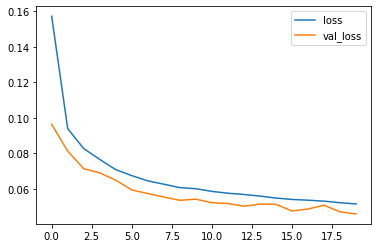

In [50]:
plt.figure(figsize=(8,5))
pd.DataFrame(archive.history).plot()
plt.show()

# Save model after training, load model function(H5)

In [51]:
# Save data after training Epoch1_3:52pm 07/August/2022
model.save('epoch20_DP4_dense-64-128-64_DP4_trainer.h5')
# Load model data
model = tf.keras.models.load_model('epoch20_DP4_dense-64-128-64_DP4_trainer.h5')

# Prediction data

In [52]:
input_text = vectorizer('russian idiot noob')

In [53]:
df.columns[2:]

Index(['Toxic', 'SevereToxicity', 'ObsceneLanguage', 'Insult'], dtype='object')

In [54]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 616ms/step


array([[0.959 , 0.1757, 0.877 , 0.6567]], dtype=float16)

In [55]:
batch = test.as_numpy_iterator().next()

In [56]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [57]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 56ms/step


array([[0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 1, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [58]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 56ms/step


In [59]:
res

array([[0.959 , 0.1757, 0.877 , 0.6567]], dtype=float16)

In [60]:
res.shape

(1, 4)

# Model Evaluation

In [61]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [62]:
model_pre = Precision()
model_rec = Recall()
model_acc = CategoricalAccuracy()

In [63]:
for batch in test.as_numpy_iterator(): 
    
    # Unpack the batch 
    X_true, y_true = batch
    
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    model_pre.update_state(y_true, yhat)
    model_rec.update_state(y_true, yhat)
    model_acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 41ms/step


In [64]:
print(f'Precision: {model_pre.result().numpy()},Recall:{model_rec.result().numpy()}, Accuracy:{model_acc.result().numpy()}')

Precision: 0.8611869215965271,Recall:0.813466489315033, Accuracy:0.48692402243614197


# 5. Test and Gradio

In [65]:
!pip install gradio jinja2

In [66]:
import tensorflow as tf
import gradio as gr

In [67]:
input_str = vectorizer('fucking noob china man')

In [68]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 77ms/step


In [69]:
res

array([[0.974 , 0.303 , 0.9536, 0.739 ]], dtype=float16)

In [70]:
def score_comment(Chat):
    vectorized_comment = vectorizer([Chat])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [71]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Type to evaluate'),
                        outputs='text')

C:\Anaconda\envs\tf_2.9\lib\site-packages\gradio\inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Anaconda\envs\tf_2.9\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Anaconda\envs\tf_2.9\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Anaconda\envs\tf_2.9\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [72]:
interface.launch(share=False)

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x1b7d46c8fd0>, 'http://127.0.0.1:7860/', None)

1/1 [==============================] - 0s 373ms/step
